# Practice Session 09: Viral Propagation

<font size="+2" color="blue">Additional results: targeted immunization</font>

# 1. The SFHH Conference Dataset

In [107]:
import io
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [108]:
INPUT_FILENAME = "sfhh-conference-2009.csv"

In [109]:
# LEAVE AS-IS

# Create a new undirected graph
g = nx.Graph()

with io.open(INPUT_FILENAME) as input_file:
    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')
    
    # Iterate through records, each record is a dictionary
    for record in reader:
        
        # Add one edge per record
        g.add_edge(record['Source'], record['Target'])

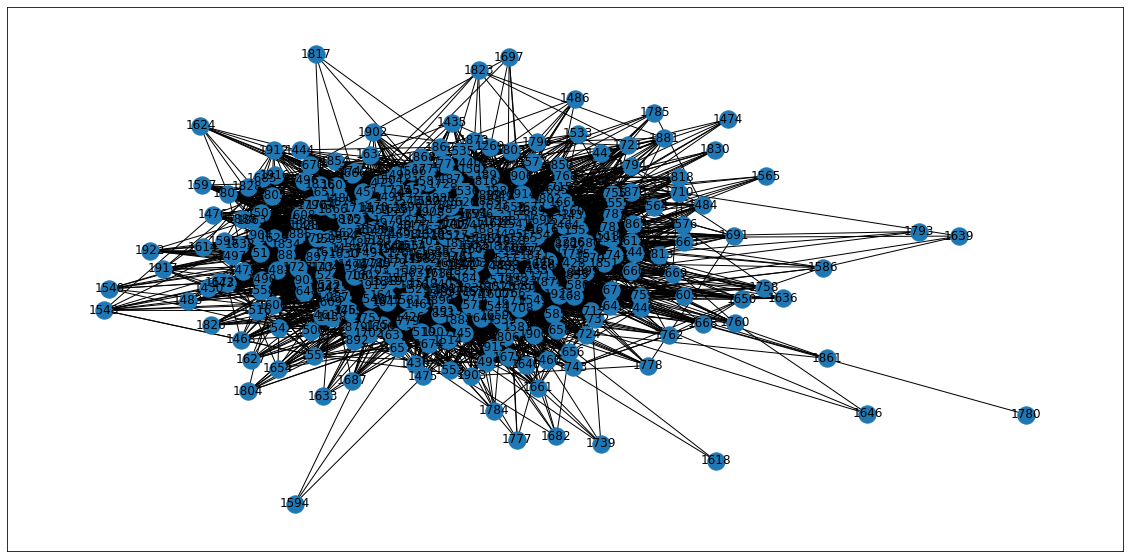

In [110]:
# LEAVE AS-IS

# Create an empty figure; feel free to change size to accommodate to your screen
plt.figure(figsize=(20,10))

# Draw the graph
nx.draw_networkx(g)

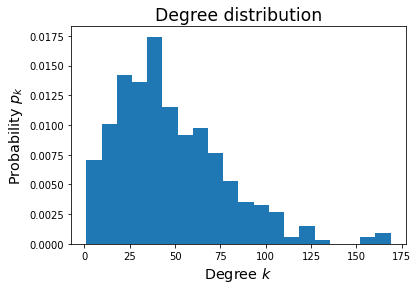

Degree: 47.5 +/- 30.1, range [1, 169]


In [111]:
# LEAVE AS-IS

def plot_degree_dist(graph):
    
    # Obtain the sequence of degree of nodes
    # Function graph.degree() return tuples (node,degree)
    degrees = [degree_tuple[1] for degree_tuple in graph.degree()]
    
    # Draw the histogram of the degree
    plt.hist(degrees, density=True, bins=20)
    plt.title("Degree distribution", fontdict={'fontsize': 'xx-large'})
    plt.xlabel("Degree $k$", fontdict={'fontsize': 'x-large'})
    plt.ylabel("Probability $p_k$", fontdict={'fontsize': 'x-large'})
    plt.show()
    
    # Print some degree statistics
    print("Degree: {:.1f} +/- {:.1f}, range [{:d}, {:d}]".format(
        np.mean(degrees), np.std(degrees), np.min(degrees), np.max(degrees)))
    
plot_degree_dist(g)

<font size="+1" color="black">Esta red no es una red libre de escala debido a que su distribución de grado no sigue una ley de potencias y tampoco es linealmente descendente, tal y como son las redes libre de escala, sino que es más parecida a la de la red libre de escala, debido a que la distribución de grado sigue una distribución de Poisson, donde la mayoría de nodos se acumulan en la media.</font>

# 2. Independent cascade model

In [112]:
def infect_recursive(graph, starting_node, beta, infected):
    infected[starting_node] = True #infectamos el nodo de entrada
    for neighbor in graph.neighbors(starting_node): #para cada uno de sus vecinos
      if infected[neighbor] == False: #comprobamos si están infectados
        r = random.uniform(0,1) #si no lo están los infectamos con una probabilidad beta
        if r < beta:
          infect_recursive(graph, neighbor, beta, infected) #llamada recursiva con el vecino a infectar

def simulate_independent_cascade(graph, starting_node, beta):
    infected = dict([(node, False) for node in graph.nodes()]) #creamos el diccionario
    infect_recursive(graph, starting_node, beta, infected) #llamada recursiva con el nodo inicial
    return infected

In [113]:
def simulate_multiple_independent_cascades(graph, beta, repetitions):
  total = 0
  for i in range(repetitions):
    node = random.choice(list(graph.nodes())) #elegimos un nodo aleatoriamente
    d = simulate_independent_cascade(graph, node, beta) #creamos el diccionario de los nodos infectados
    total += sum(d.values())/graph.number_of_nodes() #sumamos el porcentaje de noos infectados
  return total/repetitions #dividimos el total entre el número de repeticiones y retornamos la media

In [114]:
# LEAVE AS-IS

REPETITIONS=100
for beta in [0.01, 0.1, 0.2, 0.9, 1.0]:
    print("Beta={:.2f}; Fraction of infected={:.6f} (average of {:d} runs)".format(
        beta,
        simulate_multiple_independent_cascades(g, beta, REPETITIONS),
        REPETITIONS
    ))


Beta=0.01; Fraction of infected=0.005633 (average of 100 runs)
Beta=0.10; Fraction of infected=0.859082 (average of 100 runs)
Beta=0.20; Fraction of infected=0.975509 (average of 100 runs)
Beta=0.90; Fraction of infected=0.989851 (average of 100 runs)
Beta=1.00; Fraction of infected=1.000000 (average of 100 runs)


Text(0, 0.5, 'Expected fraction of infected nodes')

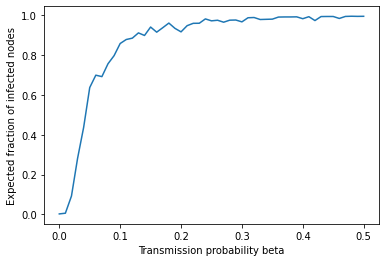

In [115]:
d = {} 
for beta in np.arange(0.0, 0.51, 0.01): #iteramos para cada valor de beta
  d[beta] = simulate_multiple_independent_cascades(g, beta, REPETITIONS)
x_vals = sorted(d.keys())
y_vals = [d[x] for x in x_vals]
plt.plot(x_vals, y_vals)
plt.xlabel("Transmission probability beta")
plt.ylabel("Expected fraction of infected nodes")

<font size="+1" color="black">
A partir de 0.02 aproximadamente hay un incremento exagerado en el número medio de infectados, lo cual es debido a que 0.01 es un valor muy pequeño y es muy probable que el starting_node no consiga propagar nada la enfermedad. En cambio, a partir de 0.02 ya hay una brecha y pese a que sigue siendo un número muy bajo abre un abanico de posibilidades de contagio más aún teniendo en cuenta nuestro grafo que es particularmente denso, lo cual eleva considerablemente la media, hasta el punto en que con una probabilidad de transmisión del 10% ya se contagian el 80% de los nodos. La densidad del grafo y el grado de los nodos tiene un papel muy importante aquí, puest que con todos los enlaces de este grafo un 10% permite contagiar prácticamente todo el nodo, pero si el grafo fuera mucho más esparso sería menos probable una dispersión tan rápida.</font>

# 3. Reduce maximum degree

In [116]:
def graph_max_degree(graph, max_degree):
  g_copy = nx.Graph()
  for node in graph.nodes():
    g_copy.add_node(node) #añadimos cada nodo
  for u,v in np.random.permutation(graph.edges()):
    if g_copy.degree(u) < max_degree and g_copy.degree(v) < max_degree: 
      g_copy.add_edge(u,v) #si ambos nodos tienen menor grado que max_degree creamos su enlace
  return g_copy

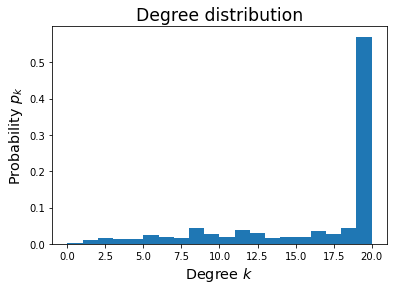

Degree: 16.0 +/- 5.6, range [0, 20]


In [117]:
# LEAVE AS-IS

# Reduce the max degree of the graph
gmax = graph_max_degree(g, 20)

# If you notice nodes with degree larger than specified,
# it means your graph_max_degree function is deffective.
plot_degree_dist(gmax)

Text(0, 0.5, 'Expected fraction of infected nodes')

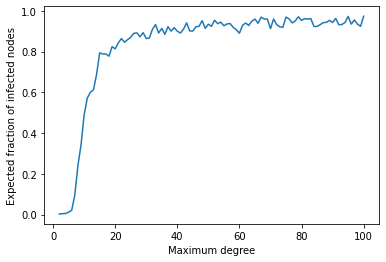

In [118]:
BETA = 0.2
d = {} 
for max in np.arange(2, 101, 1): #iteramos para cada valor de maximum degree
  new_graph = graph_max_degree(g, max)
  d[max] = simulate_multiple_independent_cascades(new_graph, BETA, REPETITIONS)
x_vals = sorted(d.keys())
y_vals = [d[x] for x in x_vals]
plt.plot(x_vals, y_vals)
plt.xlabel("Maximum degree")
plt.ylabel("Expected fraction of infected nodes")

<font size="+1" color="black">
Para evitar el contagio de la mitad de la gente deberíamos establecer un grado máximo aproximado de 5.En el gráfico anterior observábamos que para una beta=0.2 había un porcentaje de contagiados de más de un 90%, en cambio en este gráfico observamos que cambiando el grado máximo se podría disminuir drásticamente, aunque éste debería ser inferior a 20, de lo contrario habría una probabilidad de contagio muy parecida a la que se apreciaba ya en el gráfico anterior.</font>

# 4. Random vs friendship paradox immunization

In [119]:
def give_immunity_random(graph, fraction):
  immunity = dict([(node, False) for node in graph.nodes()]) #creamos el diccionario de immunidad con todos los nodos con False
  while sum(immunity.values()) < fraction * graph.number_of_nodes(): #detenemos el bucle al alcanzar dicha fracción 
    node = random.choice(list(graph.nodes())) #elegimos un nodo aleatorio
    immunity[node] = True #immunizamos dicho nodo. Si éste ya está immunizado el bucle seguirá buscando nodos aleatorios
  return immunity

In [120]:
# LEAVE AS-IS

def test_immunize(graph, method, values):
    for fraction in values:
        immunity = method(g, fraction)
        number_immunized = sum(immunity.values())
        number_not_immunized = len(immunity) - number_immunized
        fraction_immunized = number_immunized / (number_immunized + number_not_immunized)
        print("Immunized {:.1f}% of nodes; got a dictionary with {:d} 'True' and {:d} 'False' values ({:.1f}% 'True')".format(
            fraction*100,
            number_immunized,
            number_not_immunized,
            fraction_immunized*100
        ))

test_immunize(g, give_immunity_random, [0.1, 0.3, 0.7])

Immunized 10.0% of nodes; got a dictionary with 41 'True' and 362 'False' values (10.2% 'True')
Immunized 30.0% of nodes; got a dictionary with 121 'True' and 282 'False' values (30.0% 'True')
Immunized 70.0% of nodes; got a dictionary with 283 'True' and 120 'False' values (70.2% 'True')


In [121]:
def give_immunity_random_friend(graph, fraction):
  immunity = dict([(node, False) for node in graph.nodes()]) #creamos el diccionario de immunidad con todos los nodos con False
  while sum(immunity.values()) < fraction * graph.number_of_nodes(): #detenemos el bucle al alcanzar dicha fracción 
    node = random.choice(list(graph.nodes())) #elegimos un nodo aleatorio
    neighbor = random.choice(list(graph.neighbors(node))) #elegimos un vecino aleatorio de dicho nodo
    immunity[neighbor] = True #infectamos dicho vecino
  return immunity

In [122]:
def give_immunity_by_degree(graph, fraction):
  immunity = dict([(node, False) for node in graph.nodes()]) #creamos el diccionario de immunidad con todos los nodos con False
  id2node = {} #creamos un diccionario para reconocer el id de los nodos
  degree = [0]*graph.number_of_nodes() #creamos una lista con 0 del grado de los nodos
  i=0
  for node in graph:
    id2node[i] = node #atribuímos un id a cada nodo en el diccionario
    degree[i] = graph.degree[node] #añadimos el grado de cada nodo i
    i+=1
  degree_ordered = sorted(enumerate(degree), key=lambda x: x[1], reverse=True) #ordenamos la lista de grados
  for i in range(int(fraction * graph.number_of_nodes())): #iteramos tantas veces como nodos immunizados deseamos
    immunity[id2node[degree_ordered[i][0]]] = True #establecemos en immunity que los nodos con mayor grado son immunizados
  return immunity


In [123]:
# LEAVE AS-IS

test_immunize(g, give_immunity_random_friend, [0.1, 0.3, 0.7])

Immunized 10.0% of nodes; got a dictionary with 41 'True' and 362 'False' values (10.2% 'True')
Immunized 30.0% of nodes; got a dictionary with 121 'True' and 282 'False' values (30.0% 'True')
Immunized 70.0% of nodes; got a dictionary with 283 'True' and 120 'False' values (70.2% 'True')


In [124]:
def infect_recursive_immune(graph, starting_node, beta, infected, immune):
  infected[starting_node] = True
  for neighbor in graph.neighbors(starting_node):
    if infected[neighbor] == False:
      r = random.uniform(0,1)
      if r < beta:
        if immune[neighbor] == False: #comprobamos que el nodo no sea immune antes de infectarlo
          infect_recursive_immune(graph, neighbor, beta, infected, immune)

def simulate_independent_cascade_immune(graph, starting_node, beta, immune):
  infected = dict([(node, False) for node in graph.nodes()])
  if immune[starting_node] == False: #si el nodo inicial es immune no hay transmisión
    infect_recursive_immune(graph, starting_node, beta, infected, immune)
  return infected


In [125]:
def simulate_multiple_independent_cascades_immune(graph, beta, repetitions,fraction, method):
  immune = method(graph, fraction) #creamos el diccionario de immunizados
  total = 0
  for i in range(repetitions): #repetimos el proceso tantas veces como repetitions
    node = random.choice(list(graph.nodes())) #elegimos un nodo aleatorio
    d = simulate_independent_cascade_immune(graph, node, beta,immune) #iniciamos el proceso de infección
    total += sum(d.values())/graph.number_of_nodes() #sumamos cada porcentaje al total
  return total/repetitions #dividimos la sumad e porcentajes entre el número de repeticiones para retornar la media

Text(0, 0.5, 'Expected fraction of infected nodes')

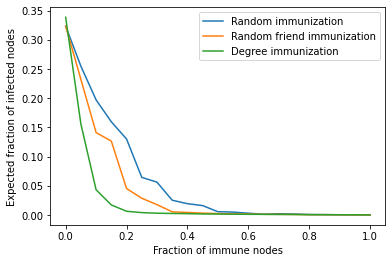

In [126]:
BETA = 0.03
REPETITIONS = 500
d = {} 
d2 = {}
d3 = {}
for fraction in np.arange(0.0, 1.05, 0.05): #iteramos para cada valor de fraction of nodes
  d[fraction] = simulate_multiple_independent_cascades_immune(g, BETA, REPETITIONS,fraction, give_immunity_random)
  d2[fraction] = simulate_multiple_independent_cascades_immune(g, BETA, REPETITIONS,fraction, give_immunity_random_friend)
  d3[fraction] = simulate_multiple_independent_cascades_immune(g, BETA, REPETITIONS,fraction, give_immunity_by_degree)

x_vals = sorted(d.keys())
y_vals = [d[x] for x in x_vals]
plt.plot(x_vals, y_vals, label = "Random immunization")
x_vals = sorted(d2.keys())
y_vals = [d2[x] for x in x_vals]
plt.plot(x_vals, y_vals, label = "Random friend immunization")
x_vals = sorted(d3.keys())
y_vals = [d3[x] for x in x_vals]
plt.plot(x_vals, y_vals, label = "Degree immunization")
plt.legend()
plt.xlabel("Fraction of immune nodes")
plt.ylabel("Expected fraction of infected nodes")

<font size="+1" color="black">En las 3 estrategias de immunización observamos dos similitudes muy básicas: la propagación llega a un máximo del 30% de la población total cuando no hay immunización, debido al valor de probabilidad de contagio beta=0.03, y acaba en 0% a partir del 50% aproximadamente para las 3 estrategias. En cambio, observamos que la fracción de contagiados decae más lento con la estrategia de immunización aleatoria que con la aleatoria por amigo. Esto es debido a la paradoja del amigo, la cual concluye que a través del mostreo indirecto es más probable obtener nodos con mayor grado que por mostreo directo. Esto es así debido a que por mostreo directo todos los nodos tienen la misma probabilidad de ser seleccionados, en cambio por mostreo indirecto aquellos nodos con más grado tienen mayor probabiliad de ser seleccionados, ya que este mostreo selecciona un vecino aleatorio de un nodo aleatorio, y cuantos más vecinos tenga un nodo más probabilidades tendrá de ser escogido.

Además observamos que a través de la tercera estrategia, la de immunización por grado, la fracción de contagiados decae mucho más rápido que en las dos estrategias anteriores. Esto es así debido que al immunizarse los nodos con mayor grado se cierran las principales vías de contagio, es decir, el mayor número de enlaces, puesto que provienen de los principales nodos, y por tanto se corta el contagio en seco. Esto es claramente demostrable en el gráfico, donde se aprecia que apenas con un 10% immunizado a través de la estrategia de grado ya habría solo un 5% de contagio, mientras que para conseguir ese porcentaje con la estrategia del amigo se necesitaría un 20% de immunización, y en la aleatoria un 30% aproximadamente. En cambio las tres coinciden en un 0% de propagación aproximadamente a partir del 50% de immunización, puesto que al immunizarse más de la mitad de nodos se cortan radicalmente las vías de contagio.</font>

# 5. Limitations

<font size="+1" color="black">
Una de las limitaciones de estas simulaciones es que se consideran todos los nodos con la misma probabilidad de contagio. Esta situación podría ser válida para algunas enfermedades de fácil contagio, pero para muchas de ellas el contagio no es igual en todas las personas y es mucho más rápido en un colectivo concreto o en un tipo de transmisión concreto. 

Otra limitación, más en el ámbito humano que estadístico, es la de la condición de cada persona y el efecto de contagio en cada una. Estas simulaciones simplemente nos muestran las formas más rápidas de cortar la propagación de una enfermedad, pero no de evitar los mayores daños, lo cual es más difícil de calcular matemáticamente. Por ejemplo, en la situación de la pandemia por el covid19 ha habido un colectivo en el que claramente el virus afectaba de forma mucho más peligrosa que en otros, por lo que la mejor estrategia sería primero immunizar a los que están más expuestos y luego tratar de cortar la transmisión tal y como plantean estas simulaciones. Si siguiéramos estas simulaciones desde el principio con el covid, por ejemplo, las personas mayores serían los últimos en vacunarse siguiendo la estrategia por grado, que era la más rápida y efectiva, puesto a que tienen menor contacto social que los jóvenes, pero en cambio los mayores son los más expuestos, por lo que esta estrategia acabaría causando muchas más muertes aunque se cortara antes la propagación. 

Por último, otra limitación de estas simulaciones es que no siempre immunizarse supone tener un 0% de probabilidad de ser contagiado, como se ha visto con la pandemia, donde estar vacunado reducía drásticamente la probabilidad de contagio, pero no la eliminaba. No obstante esto se podría implementar en el algoritmo atribuyendo una nueva beta para todos los nodos immunizados.</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>